# Итоговое задание юнита 6.
# Выбираем авто выгодно.

# Часть 1: Парсинг данных с avto.ru.

Проект посвящён вопросам качественной оценки стоимости предлагаемых автомобилей. Необходимо создать модель на основе продвинутых методов машинного обучения, не применяя технику нейронных сетей.

Отличительная черта данного проекта состоит в том, что он не содержит тренировчного набора, поэтому в процессе работы следует:
* провести анализ тестовых данных;
* самостоятельно провести сбор данных для обучения;
* провести детальный анализ и модификацию собранной информации;
* выбрать наиболее удачную модель на основе анализа данных;
* обучить модель для задачи оценки стоимости автомобиля;
* провести моделирование на основе тестовых данных;
* принять участие в соревновании на Kaggle.


Данный ноутбук предназначен для создания тренировочного набора. Проводится анализ данных в тестовом наборе затем выполняется парсинг объявлений на avto.ru.

## Импорт библиотек.

In [1]:
# Загружаем необходимые библиотеки.

# Импорт необходимых библитек.
import pandas as pd
import numpy as np

# Импорт библиотек для работы с json.
import json

# Импорт библиотек для запросов.
import requests

# Импотр библиотек для работы с файловой системой.
import os
from csv import DictWriter
from pathlib import Path

# Графика.
import matplotlib.pyplot as plt
import seaborn as sns

# Вспомогательные библиотеки.
import time
import argparse
from collections import namedtuple, defaultdict
from loguru import logger
import warnings

## Предварительные настройки.

In [2]:
# Отключаем все возможные предупреждения.
warnings.filterwarnings("ignore")

# Сброс ограничений на число столбцов.
pd.set_option('display.max_columns', None)

# Идентификатор каталога исходных данных
INPUT_PATH = './kaggle/input/sf-dst-car-price-prediction/'

OUTPUT_PATH = './my-data/'

# Шаг сохранения для csv
NUM_PAGES = 100

In [3]:
# Проводим анализ: какие файлы присутствуют в рабочем каталоге.
for dirname, _, filenames in os.walk(INPUT_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/sf-dst-car-price-prediction/cut_train.csv
./kaggle/input/sf-dst-car-price-prediction/data_2021_09_27.csv
./kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
./kaggle/input/sf-dst-car-price-prediction/test.csv
./kaggle/input/sf-dst-car-price-prediction/train.csv


## Блок функций.

In [4]:
#+++++++++++++++++++++++++++

def data_type(row):
    """
    Определяет тип данных.
    На входе: - запись из базы данных.
    На выходе: - запись с типом данных.
    """
    row = row.apply(lambda x: type(x))
    return row

#+++++++++++++++++++++++++++

def parse_auto_ru(page, folder):
    '''
    Метод парсинга сайта.
    '''

    # Если нет - создаём каталог
    folder_path = Path(folder)
    folder_path.mkdir(parents=True, exist_ok=True)

    car_list = []
    gen_prop = defaultdict(lambda: 1)

    for page_num in range(1, page + 1):
        brand = get_brand(gen_prop)
        print(f'Страница: {page_num} {brand} {gen_prop[brand]}')
        
        try:
            data_json = auto_request(gen_prop[brand], brand)
        except Exception as e:
            print(f"Ошибка: {e}")
            continue

        add_car(car_list, data_json)
        gen_prop[brand] += 1

        if page_num % NUM_PAGES == 0:
            save_data(car_list, folder, page)
            car_list = []

    save_data(car_list, folder_path, page_num)

#++++++++++++++++++++++++++++

def auto_request(pange_num, brand):
    '''
    Метод парсинга с сайта.
    '''
    
    headers = {
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
        'Connection': 'keep-alive',
        'Content-Length': '137',
        'content-type': 'application/json',
        'Cookie': '_csrf_token=1c0ed592ec162073ac34d79ce511f0e50d195f763abd8c24; autoru_sid=a%3Ag5e3b198b299o5jhpv6nlk0ro4daqbpf.fa3630dbc880ea80147c661111fb3270%7C1580931467355.604800.8HnYnADZ6dSuzP1gctE0Fw.cd59AHgDSjoJxSYHCHfDUoj-f2orbR5pKj6U0ddu1G4; autoruuid=g5e3b198b299o5jhpv6nlk0ro4daqbpf.fa3630dbc880ea80147c661111fb3270; suid=48a075680eac323f3f9ad5304157467a.bc50c5bde34519f174ccdba0bd791787; from_lifetime=1580933172327; from=yandex; X-Vertis-DC=myt; crookie=bp+bI7U7P7sm6q0mpUwAgWZrbzx3jePMKp8OPHqMwu9FdPseXCTs3bUqyAjp1fRRTDJ9Z5RZEdQLKToDLIpc7dWxb90=; cmtchd=MTU4MDkzMTQ3MjU0NQ==; yandexuid=1758388111580931457; bltsr=1; ',
        'Host': 'auto.ru',
        'origin': 'https://auto.ru/cars/all/',
        'Referer': 'https://auto.ru/cars/all/',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:72.0) Gecko/20100101 Firefox/72.0',
        'x-client-app-version': '202002.03.092255',
        'x-client-date': '1580933207763',
        'x-csrf-token': '1c0ed592ec162073ac34d79ce511f0e50d195f763abd8c24',
        'x-page-request-id': '60142cd4f0c0edf51f96fd0134c6f02a',
        'x-requested-with': 'fetch'
    }    
    
    url = 'https://auto.ru/-/ajax/desktop/listing/'
    params = dict(category='cars', section="all", output_type="list", page=pange_num,
                  catalog_filter=[{'mark': brand}], geo_id=[213], geo_radius=1000, top_days=900)
    r = requests.post(url, json=params, headers=headers)
    r.raise_for_status()
    return r.json()

#+++++++++++++++++++++++++++

def add_car(car_list, data_json):
    '''
    Метод разбора данных из json
    '''

    # Если пусто, выходим.
    if 'offers' not in data_json: return

    # Если неполные данные тоже.
    for car in data_json['offers']:
        if 'configuration' not in car['vehicle_info']:
            continue

        # Это есть всегда.
        body_type_human = car['vehicle_info']['configuration']['human_name']
        body_type = car['vehicle_info']['configuration']['body_type']
        transmission = car['vehicle_info']['tech_param']['transmission']
        engineDis = car['vehicle_info']['tech_param']['displacement']
        engineDis = round(float(engineDis) / 1000, 1)
        brand = car['vehicle_info']['mark_info']['name']
        model = car['vehicle_info']['model_info']['name']
        sell_id = car['saleId']
        section = car['section']
        car_url = f'https://auto.ru/cars/{section}/sale/{brand.lower()}/{model.lower()}/{sell_id}/'        

        # Особо обрабатываем.
        # Дата выхода
        try:
            purchase_date = car['documents']['purchase_date']
        except KeyError:
            purchase_date = None

        # Число владельцев
        try:
            owners = car['documents']['owners']
        except KeyError:
            owners = None

        # Описание
        try:
            description = car['description']
        except KeyError:
            description = None
         
        # ПТС
        try:
            pts = car['documents']['pts']
        except KeyError:
            pts = None
         
        # Валюта
        try:
            price = car['price_info']['RUR']
        except KeyError:
            continue

    # Формируем структуру данных.   
    info = cite_info(bodyType=body_type_human,
                       brand=brand,
                       car_url=car_url,
                       image=car['state']['image_urls'][0]['sizes']['small'],
                       color=car['color_hex'],
                       complectation_dict=car['vehicle_info']['complectation'],
                       equipment_dict=car['vehicle_info']['equipment'],
                       model_info=car['vehicle_info']['model_info'],
                       model_name=model,
                       location=car['seller']['location']['region_info']['name'],
                       parsing_unixtime=car['additional_info']['fresh_date'],
                       priceCurrency=car['price_info']['currency'],
                       sell_id=sell_id,
                       super_gen=car['vehicle_info']['super_gen'],
                       vendor=car['vehicle_info']['vendor'],
                       fuelType=car['vehicle_info']['tech_param']['engine_type'],
                       modelDate=car['vehicle_info']['super_gen']['year_from'],
                       name=car['vehicle_info']['tech_param']['human_name'],
                       numberOfDoors=car['vehicle_info']['configuration']['doors_count'],
                       productionDate=car['documents']['year'],
                       vehicleConfiguration=body_type + " " + transmission + " " + str(engineDis),
                       vehicleTransmission=transmission,
                       engineDisplacement=str(engineDis) + ' LTR',
                       enginePower=str(car['vehicle_info']['tech_param']['power']) + ' N12',
                       description=description,
                       mileage=car['state']['mileage'],
                       Привод=car['vehicle_info']['tech_param']['gear_type'],
                       Руль=car['vehicle_info']['steering_wheel'],
                       Состояние=car['state']['state_not_beaten'],
                       Владельцы=owners,
                       ПТС=pts,
                       Таможня=car['documents']['custom_cleared'],
                       Владение=purchase_date,
                       price=price
                       )
    # Сохраняем.
    car_list.append(info)

#+++++++++++++++++++++++++++        

def save_data(car_list, output_folder, page):
    '''
    Метод записи данных в csv формате.
    '''
    
    # Нет данных выходим.
    if not car_list: 
        return

    filename = output_folder + 'train_' + str(page) + '.csv'
    with open(filename, 'w', encoding='utf-8', newline='') as f:
        print(f'Записан файл {filename}')
        wr = DictWriter(f, fieldnames=columns)
        wr.writeheader()
        wr.writerows([car._asdict() for car in car_list])

#+++++++++++++++++++++++++++        

def get_brand(gen_prop):
    '''
    Метод выбора бренда для парсинга.
    '''    
    
    count = sum(val for val in gen_prop.values())
    brand_proportion = {key: val / count for key, val in gen_prop.items()}

    proportion_in_test_copy = proportion_in_test.copy()
    for key, val in brand_proportion.items():
        proportion_in_test_copy[key] -= val

    return sorted(proportion_in_test_copy.items(), key=lambda x: x[1], reverse=True)[0][0]

#+++++++++++++++++++++++++++

## 1.1. Предварительный анализ.

Итак: у нас есть только файл с тестовым набором. Загружаем его.

In [5]:
test = pd.read_csv(INPUT_PATH+'test.csv')   # Тестовый набор.

Проведём беглый обзор данных.

In [6]:
test.sample(20) # Тестовый набор.

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
23361,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,серебристый,NaN,CОСТОЯНИЕ НОВОГО АВТОМОБИЛЯ...!!! 100% ГАРАНТИ...,1.6 LTR,110 N12,NaN,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,22000,2014,"{""code"":""POLO"",""name"":""Polo"",""ru_name"":""Поло"",...",POLO,1.6 AT (110 л.с.),4,1603213450,RUB,2016,1101292868,"{""id"":""20726520"",""displacement"":1598,""engine_t...",SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
23415,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,белый,NaN,Машина просто в отличном состоянии два комплек...,1.8 LTR,152 N12,NaN,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,163000,2008,"{""code"":""PASSAT_CC"",""name"":""Passat CC"",""ru_nam...",PASSAT_CC,1.8 AMT (152 л.с.),4,1603213666,RUB,2011,1099379986,"{""id"":""4556000"",""displacement"":1798,""engine_ty...",SEDAN ROBOT 1.8,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
13019,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/almera/1...,белый,NaN,Машина под такси лицензия до 25г в комплекте ...,1.6 LTR,102 N12,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,248214,2012,"{""code"":""ALMERA"",""name"":""Almera"",""ru_name"":""Ал...",ALMERA,1.6 AT (102 л.с.),4,1603276912,RUB,2014,1098448092,"{""id"":""9279341"",""displacement"":1598,""engine_ty...",SEDAN AUTOMATIC 1.6,автоматическая,JAPANESE,3 или более,6 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
22559,седан,LEXUS,https://auto.ru/cars/used/sale/lexus/ls/110111...,чёрный,NaN,Выгода до 60 000 руб. при обмене на Ваш автомо...,4.6 LTR,370 N12,"{""cruise-control"":true,""asr"":true,""roller-blin...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,139211,2012,"{""code"":""LS"",""name"":""LS"",""ru_name"":""LS"",""morph...",LS,460 4.6 AT (370 л.с.) 4WD,4,1603299813,RUB,2012,1101111532,"{""id"":""8454989"",""name"":""460"",""nameplate"":""460""...",SEDAN AUTOMATIC 4.6,автоматическая,JAPANESE,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
17388,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/c_klas...,белый,NaN,Продаю свой автомобиль. Я хозяин. Дата выпуска...,1.8 LTR,156 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,73000,2006,"{""code"":""C_KLASSE"",""name"":""C-Класс"",""ru_name"":...",C_KLASSE,180 BlueEFFICIENCY 1.8 AT (156 л.с.),4,1603247663,RUB,2010,1100287634,"{""id"":""20494448"",""name"":""180"",""nameplate"":""180...",SEDAN AUTOMATIC 1.8,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен
23667,хэтчбек 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,серебристый,NaN,"Машина, один большой плюс, очень экономная, тр...",1.4 LTR,70 N12,"{""airbag-rear-side"":true,""asr"":true,""esp"":true...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,240000,2005,"{""code"":""POLO"",""name"":""Polo"",""ru_name"":""Поло"",...",POLO,1.4d MT (70 л.с.),5,1603214652,RUB,2008,1101295836,"{""id"":""2309687"",""displacement"":1422,""engine_ty...",HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
31850,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/s_klas...,чёрный,NaN,Автомобиль в отличном техническом состоянии. Я...,5.5 LTR,388 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/cSRr96A18/708ec0RhY5...,129000,2009,"{""code"":""S_KLASSE"",""name"":""S-Класс"",""ru_name"":...",S_KLASSE,500 Long 5.5 AT (388 л.с.) 4WD,4,1603591273,RUB,2010,

In [7]:
test.info() # Тестовый набор.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Сделаем краткие выводы предварительные выводы.

Мы видим, что набор содержит 32 признака. Естественно, что в тестовом наборе нет целевого признака "price". Количество записей тестовом наборе равна 34686. Чуть меньше, чем в предыдущем проекте, но признаков больше.
Дополнительно присутствуют пропуски в столбцах (в порядке возрастания) "ПТС", "equipment_dict", "Владение", "complectation_dict", 

На первый взгляд суть признаков следующая:
* bodyType - вид транспортного средства (седан, джип, кабриолет,..);
* brand - марка автомобиля;
* car_url - скорее всего ссылка на объявление (попробовать проверить);
* color - цвет автомобиля;
* complectation_dict - некое описание комплектации;
* description - какая-то полезная информация по автомобилю;
* car - флаг наличия автомобиля;
* engineDisplacement - кубики двигателя;
* enginePower - количество лошадиных сил;
* fuelType - тип топлива;
* image - ссылка на фото (попробовать проверить);
* mileage - пробег;
* modelDate - год начала продаж (ну или когда презентовали эту модель);
* model_name - модель автомобиля;
* name - некая спецификация;
* numberOfDoors - количество дверей;
* parcing_unix_date - какая-то странная дата..;
* priceCurrency - валюта, в которой продаётся автомобиль;
* productionDate - год выпуска;
* sell_id - наверное идентификатор продавца;
* super_gen - вспомогательная информация;
* vehicleConfiguration - конфигурация автомобиля;
* vehicleTransmission - тип кпп;
* vendor - место производства;
* Владельцы - количество владельцев;
* Владение - срок нахождения у владельца;
* ПТС - полагаю, либо оригинал, либо дубликат;
* Привод - передний, задний;
* Руль - расоложение руля;
* Состояние - не бита, не крашена, ездила девушка;
* Таможня - даёт добро.

Итак попробуем найти по url объявления или хотя бы фото.

In [8]:
print('Объявление: '+test.car_url.loc[0]) # По url объявления.
print('Фотография: '+test.image.loc[0]  )  # По url фото.

Объявление: https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/
Фотография: https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7CxRKU17ysuJYxu9oaUHn7ahNSrqiKwm-CQDyDolDeEoEc3J49fgWYNYBUbQC7D96sj6K9_O-mo6XT34oWVQDBTEybGZikaX4X4bwLyUujf_KICqw3ygs2UNJlXu4Og#DSD


Но увы, автомобиль уже продан..

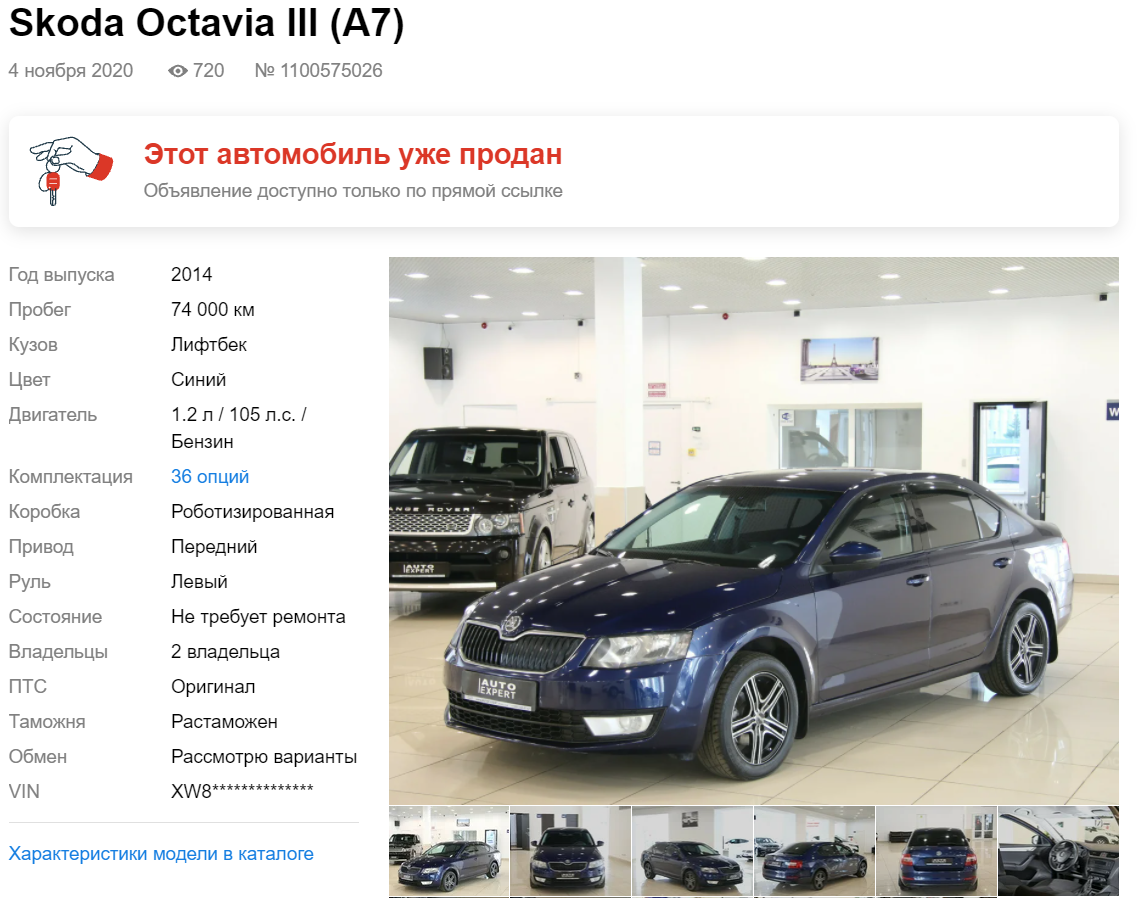

А в столбце image похоже храняться дополнительные фото из салона.

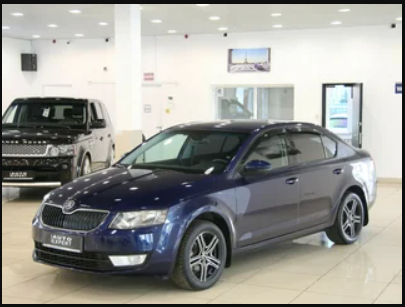

## 1.2. Анализ пропусков.

Проверим и визуализируем пропуски.

	Пропуски тестового набора


bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

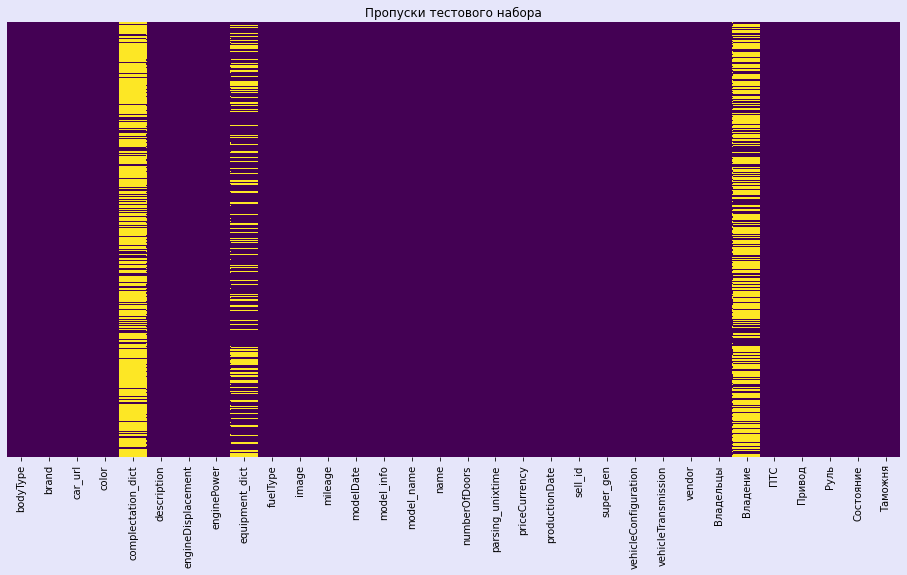

In [9]:
print('\tПропуски тестового набора')
display(test.isnull().sum())  # Тестовый набор.

# Визуализируем пропуски.
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax);

# Подписываем.
ax.set_title("Пропуски тестового набора");

С этим надо будет что-то делать. Более подробный анализ и заполнение будет проведено позже во второй части проекта.

## 1.3. Предварительный анализ признаков.

Более внимательно взглянем, какие данные лежат в наших признаках.
Посмотрим сколько из них уникальных.

In [10]:
test.nunique(axis=0) # Выполняем операцию по столбцам.

bodyType                   24
brand                      12
car_url                 34686
color                      16
complectation_dict       2364
description             31732
engineDisplacement         55
enginePower               315
equipment_dict          23705
fuelType                    5
image                   34557
mileage                 11268
modelDate                  66
model_info                954
model_name                544
name                     2780
numberOfDoors               5
parsing_unixtime        34686
priceCurrency               1
productionDate             69
sell_id                 34686
super_gen                5890
vehicleConfiguration      634
vehicleTransmission         4
vendor                      2
Владельцы                   3
Владение                  275
ПТС                         2
Привод                      3
Руль                        2
Состояние                   1
Таможня                     1
dtype: int64

Итак, что у нас есть из интересного и не очень:
* типов кузовов 24;
* марок 12;
* 16 цветов;
* 5 типов топлива;
* 5 типов разновидностей количества дверей;
* одна валюта - сомнительный признак, хотя неизвестно, как дальше пойдёт;
* 4 типа кпп;
* максимум 3 владельца;
* нет проблем с таможней - первый клиент на вылет;
* состояние - втрой;
* рули и ПТС ожидаемо 2;
* идентификатор продавца;
* два производителя - Азия, Европа;
* и 3 типа приводов: передний, задний, полный.

С остальными придётся плотно поработать позже.

Предлагаю начать с признака "brand".

In [11]:
test.brand.value_counts() # Узнаем какие есть марки и сколько их.

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

То есть у нас есть только иномарки вышеуказанных 12 брендов, следовательно при подготовке данных для обучения следует выбирать автомобили этих марок.

Посмотрим какие цвета пользуются популярностью.

In [12]:
test.color.value_counts() # Узнаем какие есть цвета и сколько их.

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

Вполне обычный набор колоров, от классики до розового.

Теперь взгляенем по объёму двигателя

In [13]:
test.engineDisplacement.value_counts() # Узнаем какие есть объёмы и сколько их.

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
 LTR         55
2.6 LTR      55
0.7 LTR      53
6.0 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
5.3 LTR       1
3.9 LTR       1
Name: engineDisplacement, dtype: int64

Видно, что объём приводится в литрах.

Проверим признак мощности двигателя.

In [14]:
test.enginePower.value_counts() # Узнаем какие есть мощности и сколько их.

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
514 N12       1
485 N12       1
127 N12       1
30 N12        1
44 N12        1
Name: enginePower, Length: 315, dtype: int64

Тип топлива.

In [15]:
test.fuelType.value_counts() # Аналогично.

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

Тип трансмиссии.

In [16]:
test.vehicleTransmission.value_counts() # Аналогично.

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

Возьмём на заметку, что автомобилей с автоматическая кпп больше, чем остальных вместе взятых.

Число дверей.

In [17]:
test.numberOfDoors.value_counts() # Аналогично.

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

Очень интересный случай, это как так чтоб, ни одной двери. Может ошибка? Проверим.

In [18]:
test[test.numberOfDoors==0] # Любопытный экзепляр.

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0,1603245843,RUB,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен


Ничего себе! 1904 год! 1 владелец! Не уж то Николай II?!
Шутки шутками, а такие машины придётся оценивать..

Наименование.

In [19]:
test.name.sample(10) # Аналогично.

23354                     3.0d AT (240 л.с.) 4WD
3718                  Long 3.0 AT (310 л.с.) 4WD
11728                     2.0d AT (150 л.с.) 4WD
30524                         1.6 AMT (102 л.с.)
16287               300 d 2.0d AT (245 л.с.) 4WD
5293                           1.7 MT (125 л.с.)
15090    FX Vettel Edition 5.0 AT (420 л.с.) 4WD
12150                     2.5d AT (190 л.с.) 4WD
29517         520d xDrive 2.0d AT (190 л.с.) 4WD
21445                      2.7 AT (163 л.с.) 4WD
Name: name, dtype: object

В целом бессмысленный столбец сам по себе, но из него можно извлечь недостающее.

Конфигурация транспортного средства.

In [20]:
test.vehicleConfiguration.value_counts()  # Аналогично.

ALLROAD_5_DOORS AUTOMATIC 3.0    2389
SEDAN AUTOMATIC 2.0              1610
ALLROAD_5_DOORS AUTOMATIC 2.0    1327
ALLROAD_5_DOORS VARIATOR 2.0     1323
SEDAN MECHANICAL 1.6             1314
                                 ... 
CABRIO AUTOMATIC 3.5                1
WAGON_5_DOORS AUTOMATIC 4.4         1
LIMOUSINE AUTOMATIC 6.2             1
ALLROAD_OPEN AUTOMATIC 2.0          1
COUPE_HARDTOP AUTOMATIC 2.3         1
Name: vehicleConfiguration, Length: 634, dtype: int64

Аналогично предыдущему - из него можно выбрать недостающие данные.

Посмотрим, какие модели присутствуют в тестовом наборе.

In [21]:
test.model_name.value_counts() # Аналогично

OCTAVIA       1418
5ER           1026
LANCER         855
E_KLASSE       809
PASSAT         782
              ... 
200SX            1
X_KLASSE         1
EMERAUDE         1
100_SERIES       1
E3               1
Name: model_name, Length: 544, dtype: int64

Для меня это открытие. Я всегда думал, что Октавии это строго Шкода, а на первом месте Мерседесы. Оказывается есть и другие марки Октавии!

Ознакомимся с пробегом.

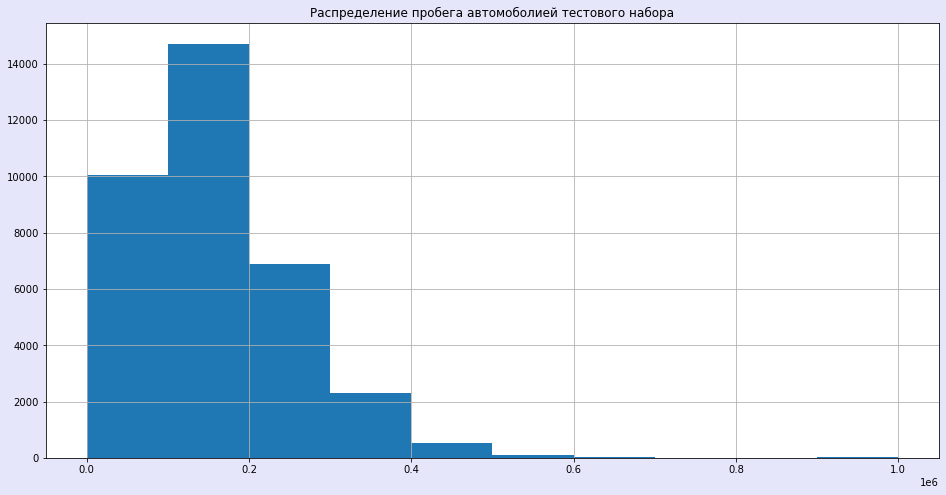

In [22]:
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
test['mileage'].hist(ax=ax)

# Подписываем.
ax.set_title("Распределение пробега автомоболией тестового набора");

В целом распределение без каких-либо сложностей. Вполне ожидаемо.

Год выпуска/презентации модели.

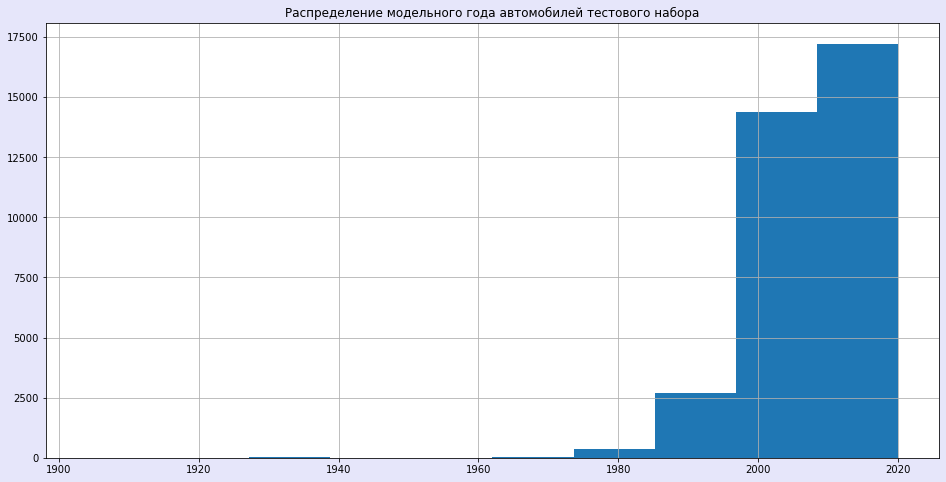

In [23]:
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
test['modelDate'].hist(ax=ax)

# Подписываем.
ax.set_title("Распределение модельного года автомобилей тестового набора");

В наборе довольно новые модели, так же присутствуют и раритеты. К ним надо будет отнестись аккуратно и постараться спарсить и старые авто.

Год выпуска автомобиля.

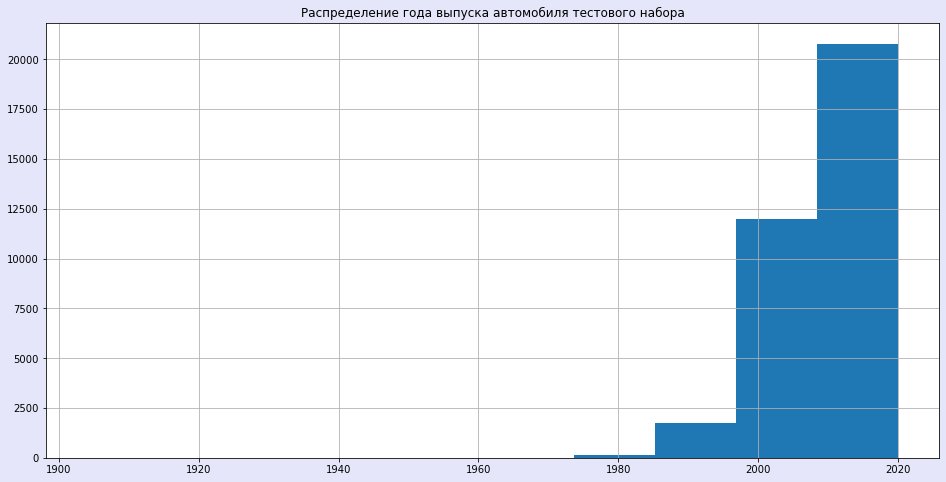

In [24]:
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
test['productionDate'].hist(ax=ax)

# Подписываем.
ax.set_title("Распределение года выпуска автомобиля тестового набора");

Год выпуска очень коррелирует с модельным годом, возможно придётся от одного отказаться.

Следующие стоблцы "model_info", "complectation_dict" представляют собой вспомогательную информацию, поля которых содеражат информацию в формате json, как, например, "equipment_dict".

In [25]:
test.equipment_dict.sample(10) # Посмотрим на json столбец.

4630                                                   NaN
27577                                                  NaN
27188                                                  NaN
28490                                                  NaN
20639    {"engine-proof":true,"asr":true,"esp":true,"au...
10762    {"cruise-control":true,"asr":true,"esp":true,"...
5303                                                   NaN
129      {"engine-proof":true,"cruise-control":true,"as...
3491     {"alloy-wheel-disks":true,"16-inch-wheels":tru...
11350    {"cruise-control":true,"tinted-glass":true,"es...
Name: equipment_dict, dtype: object

Признак "description" представляет собой текстовую строку с описанием автомобиля. Возможно это будет полезно.

In [26]:
# Случайный образец текстовой информации объявления
test.description.sample(1).iloc[0]

'Продаю Audi A6 C7, модельный ряд 2013 года.\nАвтомобиль юридически чистый, не находится ни в кредите, ни в залоге.\nСостояние – сел и поехал.\nУхоженный не прокуренный салон.\nФактическое количество владельцев - трое, остальное перевес номеров.\nЗаводской внешний и внутренний S-Line.\nУстановлен скошенный руль с перфорацией и лепестками.\nЗамена моторного масла каждые 7000 км, расход за данный интервал не превышает 500 грамм.\n2000 км назад было пройдено большое ТО с заменой масла в ДВС и замена тормозов по кругу (тормозные диски+колодки).\nНа 115.000 км полностью перебирался мехатроник с заменой масла в кпп.\nАвтомобиль после детейлинга, полностью отполирован и покрыт защитным слоем.\nУстановлены новые летние шины.\nУстановлено новое лобовое стекло. \nКомплект зимних шин липучки.\nКомплект резиновых ковриков.\n\nЛюбые проверки автомобиля за ваш счет. \nВозможен торг. \n\nВ помощи автосалонов и прочих автомобильных площадок не нуждаюсь.'

## 1.4. Парсинг auto.ru/

При подготовке данного ноутбука перед мной встала задача - как собрать как можно больше данных? В целом ситуация понятная, берём и парсим, но меня часто подводила связь. Интернет мог отрубиться, поэтому я пришёл к решению сохранять информацию порционно.

На основании предварительного анализа стало ясно, какие марки автомобилей желательно следует отбирать это Мерседес, БМВ, Фольксваген, Ниссан, Ауди, Тойота, Мицибиси, Хонда, Инфинити, Лексус, Шкода. Так же следует обратить внимнание на  пропорцию данных автомобилей в наборе.

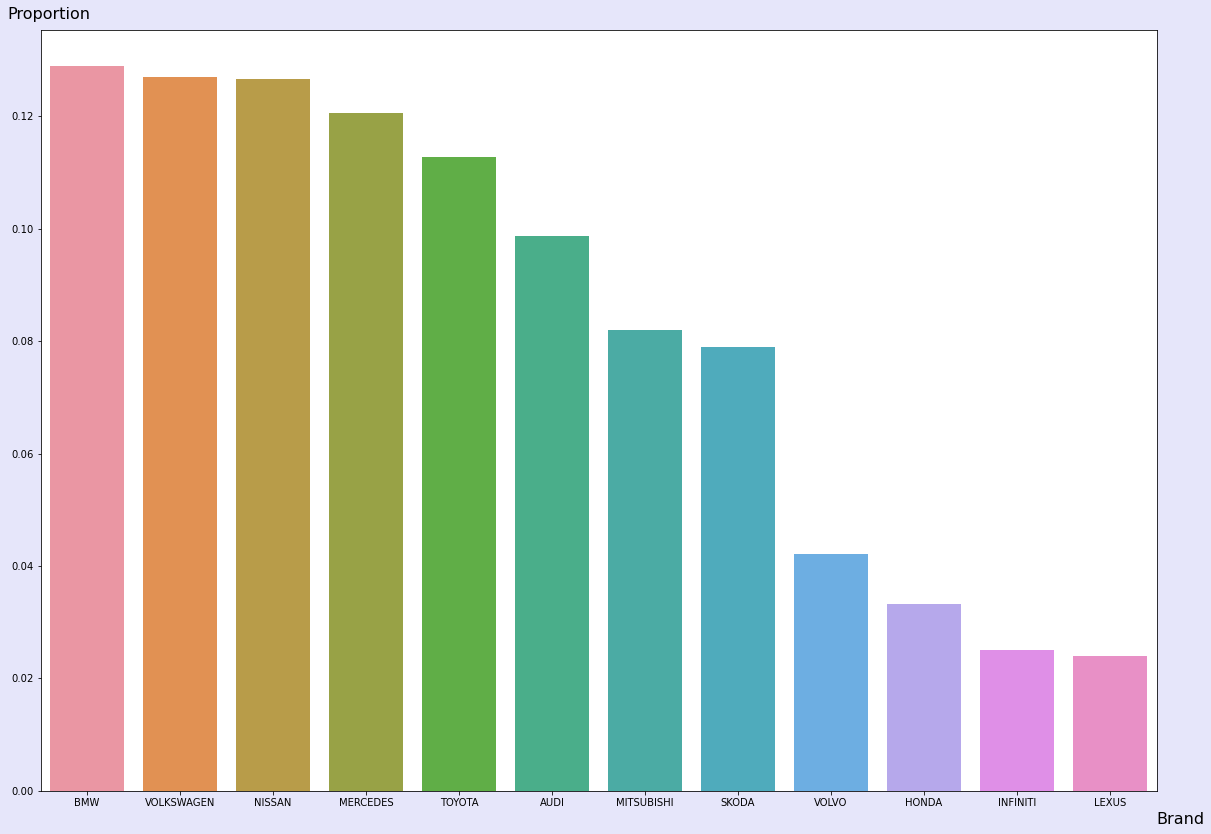

In [27]:
data_size = len(test) # Длина набора.

# Расчёт в долях.
brand = test.brand.value_counts().reset_index().rename({'index': 'Brand', 'brand': 'count'}, axis=1)
brand['count'] = brand['count'].apply(lambda x: x / data_size)
brand_val = brand['Brand'].values

# Построение гистограммы
fig, ax = plt.subplots(figsize=(20, 14), facecolor="Lavender")
# Бренды
sns.barplot(x='Brand', y='count', data=brand, ci=None, orient='v',  ax=ax, order=brand_val);
ax.set_xlabel('Brand', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
ax.set_ylabel('Proportion', rotation=0, position=(0, 1.01), ha='left', fontsize=16);

В этих долях надо стремиться собрать данные. Приступим.

Для будущего важно знать какого типа данных у нас признаки. Проверим.

In [28]:
# Делаем копию датасета.
df = test.copy();
df = df.apply(data_type)

# Посмотрим, что получилось
df.head(10)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
1,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
2,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
3,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
4,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
5,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
6,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
7,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
8,<class 'str'>,<class 'str'>,

In [29]:
# Создаём словарь.
proportion_in_test = dict(zip(brand_val, brand['count'].values))

# Списоок признаков.
columns = ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement',
           'enginePower', 'location', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate',
           'model_info', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
           'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
           'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'price']

cite_info = namedtuple('Car', columns)

# Запускаем парсер.
parse_auto_ru(100, OUTPUT_PATH) # Это просто пример. В реальности было 20000 страниц.

Страница: 1 BMW 1
Страница: 2 VOLKSWAGEN 1
Страница: 3 NISSAN 1
Страница: 4 MERCEDES 1
Страница: 5 TOYOTA 1
Страница: 6 AUDI 1
Страница: 7 MITSUBISHI 1
Страница: 8 SKODA 1
Страница: 9 VOLVO 1
Страница: 10 HONDA 1
Страница: 11 BMW 2
Страница: 12 VOLKSWAGEN 2
Страница: 13 NISSAN 2
Страница: 14 MERCEDES 2
Страница: 15 TOYOTA 2
Страница: 16 INFINITI 1
Страница: 17 AUDI 2
Страница: 18 LEXUS 1
Страница: 19 BMW 3
Страница: 20 VOLKSWAGEN 3
Страница: 21 NISSAN 3
Страница: 22 MERCEDES 3
Страница: 23 TOYOTA 3
Страница: 24 MITSUBISHI 2
Страница: 25 SKODA 2
Страница: 26 BMW 4
Страница: 27 VOLKSWAGEN 4
Страница: 28 NISSAN 4
Страница: 29 AUDI 3
Страница: 30 MERCEDES 4
Страница: 31 TOYOTA 4
Страница: 32 BMW 5
Страница: 33 MITSUBISHI 3
Страница: 34 VOLKSWAGEN 5
Страница: 35 NISSAN 5
Страница: 36 SKODA 3
Страница: 37 MERCEDES 5
Страница: 38 AUDI 4
Страница: 39 TOYOTA 5
Страница: 40 BMW 6
Страница: 41 VOLKSWAGEN 6
Страница: 42 NISSAN 6
Страница: 43 MERCEDES 6
Страница: 44 MITSUBISHI 4
Страница: 45 AUDI 5

## Выводы

Был подготовлен тренировочный набор, который будет использован в дальнейшем для построения модели машинного обучения.